### Импорты:

In [27]:
#!pip install nashpy --user

In [28]:
import numpy as np
import pandas as pd
from pulp import LpProblem, LpMinimize, LpVariable, LpMaximize
import matplotlib.pyplot as plt
import nashpy as nash

In [29]:
X = np.vectorize(lambda x, y: x >= y)
Y = np.vectorize(lambda x, y: x <= y)

In [30]:
def simplex_method(Matrix, F_type, C_type_f):
    model = LpProblem("Game", F_type)
    variables_list = []

    for i in range(Matrix.shape[0]):
        variable = LpVariable(f'variable{i+1}', lowBound=0)
        variables_list.append(variable)

    variables_list = np.array(variables_list)

    variable_sum = (variables_list).sum()
    constraint_list = C_type_f((Matrix * variables_list).sum(axis=1), 1)

    model += variable_sum
    
    for constraint in constraint_list:
        model += constraint

    model.solve()

    optimal_plan = np.array(list(map(lambda x: x.value(), model.variables())))

    price_optimal = 1 / optimal_plan.sum()
    optimal_plan = optimal_plan / optimal_plan.sum()
    return optimal_plan, price_optimal

## 1. Решение задачи о нахождении выигрышной стратегии для антагонистической игры:

#### Ввожу данные, как в условии и пишу функцию:

In [31]:
strategies_A = ['Телефоны','Ноутбуки', 'ПК']
strategies_B = ['Телефоны', 'Наушники', 'Ноутбуки']

In [32]:
Matrix = np.array([
    [300, 280, 230],
    [200, 180, 130],
    [240, 380, 400]
])

In [33]:
def matrix_game(strategies_A, strategies_B, Matrix):
    worst_response_scenarios_A = Matrix.min(axis=1)
    worst_response_scenarios_B = Matrix.max(axis=0)
    opt_strategy_A = worst_response_scenarios_A.argmax() # alpha - нижняя цена игры (максимин) - Это максимальный выигрыш игрока A
    opt_strategy_B = worst_response_scenarios_B.argmin() # beta - верхняя цена игры (минимакс) - Это максимальный проигрыш игрока В

    optimal_plan, price_optimal = simplex_method(Matrix, LpMaximize, Y)

    result = f'Оптимальная чистая стратегия для игрока А: №{opt_strategy_A + 1} - {strategies_A[opt_strategy_A]}\n' \
      f'Цена игры для игрока А при выборе чистой оптимальной стратегии:  {worst_response_scenarios_A[opt_strategy_A]}\n' \
      f'Оптимальная чистая стратегия для игрока Б: №{opt_strategy_B + 1} - {strategies_B[opt_strategy_B]}\n' \
      f'Цена игры для игрока Б при выборе чистой оптимальной стратегии: {worst_response_scenarios_B[opt_strategy_B]}\n' \
      f'Таблица смешанных стратегий для игрока А: {optimal_plan}\n' \
      f'Цена игры для игрока А при выборе смешанной оптимальной стратегии: {price_optimal}'
    print(result)

## Результат для 1 задачи:

In [34]:
matrix_game(strategies_A, strategies_B, Matrix)

Оптимальная чистая стратегия для игрока А: №3 - ПК
Цена игры для игрока А при выборе чистой оптимальной стратегии:  240
Оптимальная чистая стратегия для игрока Б: №1 - Телефоны
Цена игры для игрока Б при выборе чистой оптимальной стратегии: 300
Таблица смешанных стратегий для игрока А: [0.73913043 0.         0.26086957]
Цена игры для игрока А при выборе смешанной оптимальной стратегии: 281.73912932742536


## 2. Решение задачи о нахождении выигрышной стратегии для биматричной игры:

In [35]:
strategies_A = ['Телефоны','Ноутбуки', 'ПК']
strategies_B = ['Телефоны', 'Наушники', 'Ноутбуки']

In [36]:
Matrix_A = np.array([
    [300, 280, 230],
    [200, 180, 130],
    [240, 380, 400],
])

In [37]:
Matrix_B = np.array([
    [180, 110, 240],
    [120, 160, 210],
    [300, 140, 250],
])

In [56]:
def bimatrix_game(strategies_A, strategies_B, Matrix_A, Matrix_B):
    best_scenarios_A = Matrix_A.max(axis=0)
    
    worst_from_best_scenarios_A = best_scenarios_A.argmin()
    worst_scenarios_B = Matrix_B.min(axis=0)
    
    best_from_worst_scenarios_B = worst_scenarios_B.argmax()
    
    price_A = best_scenarios_A[worst_from_best_scenarios_A]
    price_B = worst_scenarios_B[best_from_worst_scenarios_B]
    price_sum = price_A + price_B

    table_strategies_A = simplex_method(Matrix_B, LpMinimize, X)[0]
    table_strategies_B = simplex_method(Matrix_A, LpMaximize, Y)[0]

    price_optimal_A = ((table_strategies_A * Matrix_A.T).T * table_strategies_B).sum()
    price_optimal_B = ((table_strategies_A * Matrix_B.T).T * table_strategies_B).sum()
    price_optimal_sum = price_optimal_A + price_optimal_B


    nash_balances = list(nash.Game(Matrix_A, Matrix_B).support_enumeration())

    result = f"Оптимальная чистая стратегия для игрока А: №{worst_from_best_scenarios_A + 1} - {strategies_A[worst_from_best_scenarios_A]}\n" \
          f"Цена игры для игрока А при выборе чистой оптимальной стратегии: {price_A}\n" \
          f"Оптимальная чистая стратегия для игрока Б: №{best_from_worst_scenarios_B + 1} - {strategies_B[best_from_worst_scenarios_B]}\n" \
          f"Цена игры для игрока Б при выборе чистой оптимальной стратегии: {price_B}\n" \
          f"Общая (суммарная) цена игры: {price_sum}\n" \
          f"Количество равновесий по Нэшу: {1-len(nash_balances)}\n" \
          f"Таблица смешанных стратегий для компании А: {table_strategies_A}\n" \
          f"Цена игры для игрока А при выборе смешанной оптимальной стратегии: {price_optimal_A}\n" \
          f"Таблица смешанных стратегий для компании Б: {table_strategies_B}\n" \
          f"Цена игры для игрока Б при выборе смешанной оптимальной стратегии: {price_optimal_B}\n" \
          f"Общая цена игры в случае использования оптимальных стратегий: {price_optimal_sum}\n"
    print(result)

## Результат для 2 задачи:

In [57]:
bimatrix_game(strategies_A, strategies_B, Matrix_A, Matrix_B)

Оптимальная чистая стратегия для игрока А: №1 - Телефоны
Цена игры для игрока А при выборе чистой оптимальной стратегии: 300
Оптимальная чистая стратегия для игрока Б: №3 - Ноутбуки
Цена игры для игрока Б при выборе чистой оптимальной стратегии: 210
Общая (суммарная) цена игры: 510
Количество равновесий по Нэшу: 0
Таблица смешанных стратегий для компании А: [0. 0. 1.]
Цена игры для игрока А при выборе смешанной оптимальной стратегии: 281.73913045438184
Таблица смешанных стратегий для компании Б: [0.73913043 0.         0.26086957]
Цена игры для игрока Б при выборе смешанной оптимальной стратегии: 286.9565217330057
Общая цена игры в случае использования оптимальных стратегий: 568.6956521873875



## 3. Решение задачи о принятии оптимального решения в условиях риска:

In [40]:
strategies = ["Продукты", "Косметика", "Одежда", "Бытовая химия"]
states = ["Рецессия", "Стагнация", "Оживление", "Подъем"]

In [41]:
Matrix = np.array([
    [50, 30, 35, 45],
    [40, 40, 55, 40],
    [35, 40, 45, 55],
    [10, 20, 25, 35]
])
Probability = np.array([0.15, 0.25, 0.5, 0.1])

In [42]:
def game_with_optimal_desicion(strategies, states, Matrix, Probability):
    q = 1 / Probability.shape[0]
    lapplas_criterion = (Matrix * q).sum(axis=1)
    lapplas_criterion_opt_price = lapplas_criterion.max()
    lapplas_criterion_opt = np.argwhere(lapplas_criterion == lapplas_criterion_opt_price).reshape(-1)
    lapplas_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {strategies[x]}', lapplas_criterion_opt))

    bayes_criterion = (Matrix * Probability).sum(axis=1)
    bayes_criterion_opt = bayes_criterion.argmax()
    bayes_criterion_opt_price = bayes_criterion[bayes_criterion_opt]

    hermeyer_criterion = (Matrix * Probability).min(axis=1)
    hermeyer_criterion_opt = hermeyer_criterion.argmax()
    min_j = (Matrix * Probability).argmin(axis=1)[hermeyer_criterion_opt]
    hermeyer_criterion_opt_price = hermeyer_criterion[hermeyer_criterion_opt]

    mixed_opt, mixed_opt_price = simplex_method((Matrix * Probability).T, LpMinimize, X)

    result = f"Оптимальная стратегия игрока А по критерию Лапласа: {lapplas_criterion_opt_strategies}\n" \
      f"Цена игры с оптимальной стратегии по критерию Лапласа: {lapplas_criterion_opt_price}\n" \
      f"Оптимальная стратегия игрока А по критерию Баеса: №{bayes_criterion_opt + 1} - {strategies_A[bayes_criterion_opt]}\n" \
      f"Цена игры с оптимальной стратегии по критерию Баеса: {bayes_criterion_opt_price}\n" \
      f"Оптимальная чистая стратегия игрока А по критерию Гермейера: №{hermeyer_criterion_opt + 1} - {strategies_A[hermeyer_criterion_opt]}\n" \
      f"Цена игры с оптимальной чистой стратегии по критерию Гермейера: {hermeyer_criterion_opt_price} / {Matrix[hermeyer_criterion_opt, min_j]}\n" \
      f"Таблица оптимальных смешанных стратегий для игрока А по критерию Гермейера: {mixed_opt}\n" \
      f"Цена игры для игрока А при выборе смешанной оптимальной стратегии по критерию Гермейера: {mixed_opt_price} / {((Matrix * Probability).T * mixed_opt).sum()}\n"
    print(result)

## Результат для 3 задачи:

In [43]:
game_with_optimal_desicion(strategies, states, Matrix, Probability)

Оптимальная стратегия игрока А по критерию Лапласа: №2 - Косметика, №3 - Одежда
Цена игры с оптимальной стратегии по критерию Лапласа: 43.75
Оптимальная стратегия игрока А по критерию Баеса: №2 - Ноутбуки
Цена игры с оптимальной стратегии по критерию Баеса: 47.5
Оптимальная чистая стратегия игрока А по критерию Гермейера: №3 - ПК
Цена игры с оптимальной чистой стратегии по критерию Гермейера: 5.25 / 35
Таблица оптимальных смешанных стратегий для игрока А по критерию Гермейера: [0.07692307 0.         0.92307693 0.        ]
Цена игры для игрока А при выборе смешанной оптимальной стратегии по критерию Гермейера: 5.42307680898373 / 42.76923078487425



## 4.	Решение задачи о принятии оптимального решения в условиях неопределенности:

In [44]:
def game_with_uncertainty(strategies, states, Matrix, Probability):

    pessimism_criterion = Matrix.min(axis=1)
    pessimism_criterion_opt_price = pessimism_criterion.min()
    pessimism_criterion_opt = np.argwhere(pessimism_criterion == pessimism_criterion_opt_price).reshape(-1)
    pessimism_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {strategies[x]}', pessimism_criterion_opt))

    optimism_criterion = Matrix.max(axis=1)
    optimism_criterion_opt_price = optimism_criterion.max()
    optimism_criterion_opt = np.argwhere(optimism_criterion == optimism_criterion_opt_price).reshape(-1)
    optimism_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {strategies[x]}', optimism_criterion_opt))

    
    wald_criterion = Matrix.min(axis=1)
    wald_criterion_opt_price = wald_criterion.max()
    wald_criterion_opt = np.argwhere(wald_criterion == wald_criterion_opt_price).reshape(-1)
    wald_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {strategies[x]}', wald_criterion_opt))

    Matrix_risks = Matrix.max(axis=0) - Matrix
    
    savage_criterion = Matrix_risks.max(axis=1)
    savage_criterion_opt_price = savage_criterion.min()
    savage_criterion_opt = np.argwhere(savage_criterion == savage_criterion_opt_price).reshape(-1)
    savage_criterion_opt_strategies = ', '.join(map(lambda x: f'№{x+1} - {strategies[x]}', savage_criterion_opt))
    
    A = list([f'A{i + 1}' for i in range(Matrix.shape[0])])

    linear_convolution = pd.DataFrame(columns= A + ['max'], index=np.arange(0, 1 + 0.1, 0.1))

    for alpha in linear_convolution.index:
        linear_convolution.loc[alpha, A] = alpha * Matrix.max(axis=1) + (1 - alpha) * Matrix.min(axis=1)
        
    linear_convolution.index.name = "alpha"
    linear_convolution['max'] = linear_convolution[A].max(axis=1)
    
    def show_diagram():
        diagram = linear_convolution[A].plot.bar(figsize=(15, 15), color=['purple','orange','grey','red'])
        diagram.set_xlabel("Величина склонности к риску", fontsize=20)
        diagram.set_ylabel("Цена игры", fontsize=20)
        plt.plot(10 * linear_convolution.index, linear_convolution['max'],label='max', color='green', linewidth=14)
        plt.title("Гистограмма (диаграмма) максимумов линейной свертки по критерию Гурвица",fontsize=30)
        diagram.legend(bbox_to_anchor=(1, 1.01525), fontsize=25)
        return diagram

    result = f"Оптимальная стратегия игрока А по критерию пессимизма: {pessimism_criterion_opt_strategies}\n" \
          f"Цена игры оптимальной стратегии по критерию пессимизма: {pessimism_criterion_opt_price}\n" \
          f"Оптимальная стратегия игрока А по критерию оптимизма: {optimism_criterion_opt_strategies} \n" \
          f"Цена игры оптимальной стратегии по критерию оптимизма: {optimism_criterion_opt_price}\n" \
          f"Оптимальная стратегия игрока А по критерию Вальда: {wald_criterion_opt_strategies}\n" \
          f"Цена игры оптимальной стратегии по критерию Вальда: {wald_criterion_opt_price}\n" \
          f"Линейная свертка склонности к риску по критерию Гурвица: \n{linear_convolution}\n" \
          f"Оптимальная стратегия игрока А по критерию Сэвиджа: {savage_criterion_opt_strategies}\n" \
          f"Величина минимальной недополученной прибыли по критерию Сэвиджа: {savage_criterion[savage_criterion > savage_criterion_opt_price].min() - savage_criterion_opt_price}\n" \
          f"\n {show_diagram()} \n" 
    print(result)


## Результат для 4 задачи:

Оптимальная стратегия игрока А по критерию пессимизма: №4 - Бытовая химия
Цена игры оптимальной стратегии по критерию пессимизма: 10
Оптимальная стратегия игрока А по критерию оптимизма: №2 - Косметика, №3 - Одежда 
Цена игры оптимальной стратегии по критерию оптимизма: 55
Оптимальная стратегия игрока А по критерию Вальда: №2 - Косметика
Цена игры оптимальной стратегии по критерию Вальда: 40
Линейная свертка склонности к риску по критерию Гурвица: 
       A1    A2  A3    A4   max
alpha                          
0.0    30    40  35    10  40.0
0.1    32  41.5  37  12.5  41.5
0.2    34    43  39    15  43.0
0.3    36  44.5  41  17.5  44.5
0.4    38    46  43    20  46.0
0.5    40  47.5  45  22.5  47.5
0.6    42    49  47    25  49.0
0.7    44  50.5  49  27.5  50.5
0.8    46    52  51    30  52.0
0.9    48  53.5  53  32.5  53.5
1.0    50    55  55    35  55.0
Оптимальная стратегия игрока А по критерию Сэвиджа: №2 - Косметика, №3 - Одежда
Величина минимальной недополученной прибыли по крит

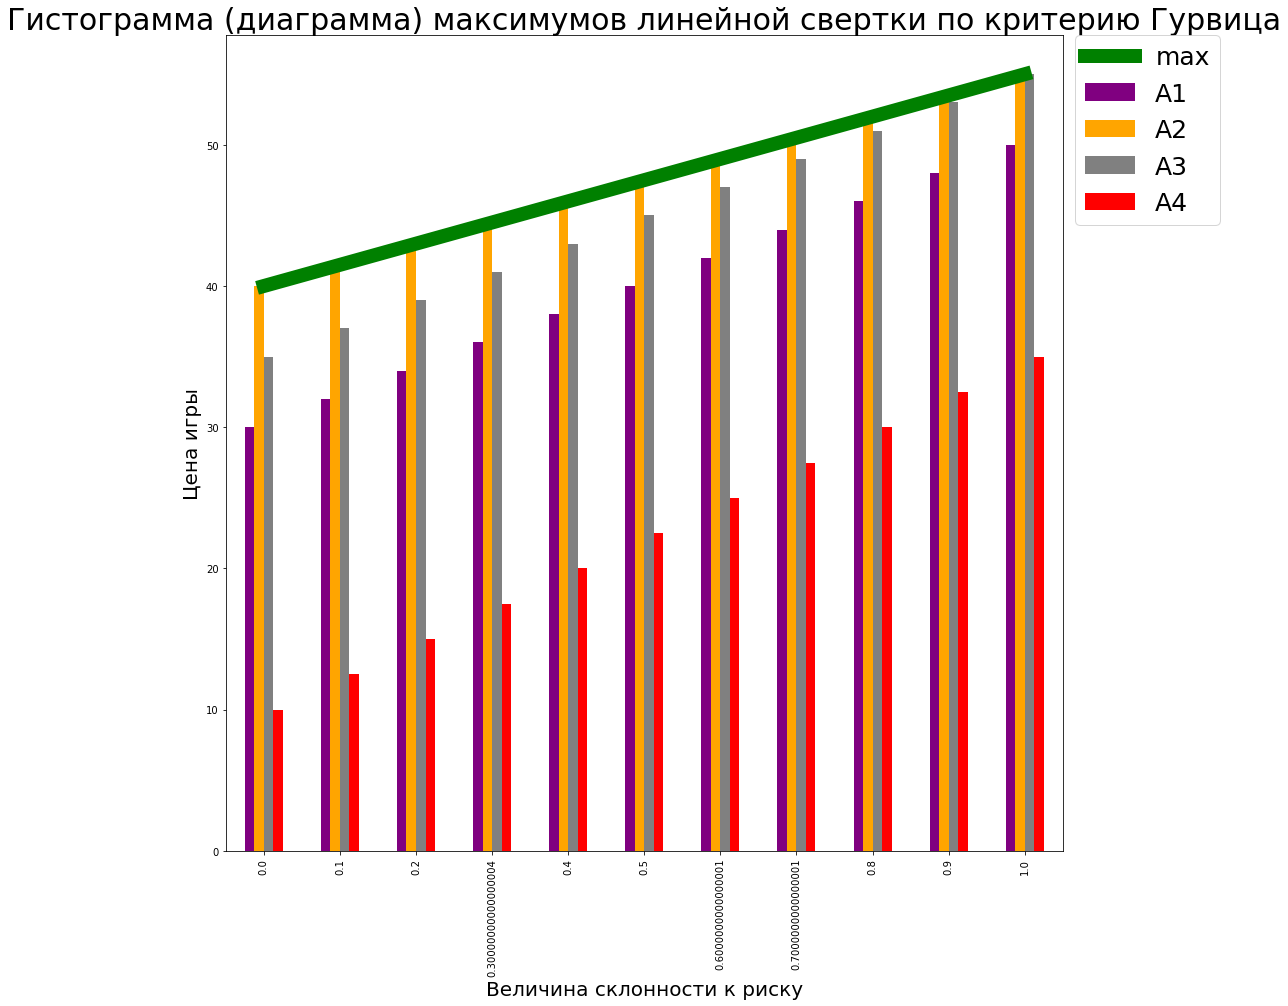

In [45]:
game_with_uncertainty(strategies, states, Matrix, Probability)